In [117]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import acf, pacf, adfuller
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import yfinance as yf

# 1. Przypadek jednowymiarowy

### **Wczytanie danych**

In [118]:
start_date = '2014-01-02'
end_date = '2024-03-31'
usd_yuan_ticker = 'CNYUSD=X'
oil_ticker = 'CL=F'
all_data = yf.download(tickers=[usd_yuan_ticker, oil_ticker], start=start_date, end=end_date)["Close"]
all_data = all_data.rename(columns={oil_ticker: "oil", usd_yuan_ticker: "currency"})

[*********************100%%**********************]  2 of 2 completed


In [119]:
date = all_data.index
Date = pd.to_datetime(date)
print(len(Date))

Oil_with = all_data["oil"]
Currency = all_data["currency"]

Oil = np.where(Oil_with < 0, np.nan, Oil_with)

2672


In [120]:
Oil = np.interp(np.arange(len(Date)), np.arange(len(Oil))[~np.isnan(Oil)], Oil[~np.isnan(Oil)])
Currency = np.interp(np.arange(len(Date)), np.arange(len(Currency))[~np.isnan(Currency)], Currency[~np.isnan(Currency)])
print(len(Oil), len(Currency))

2672 2672


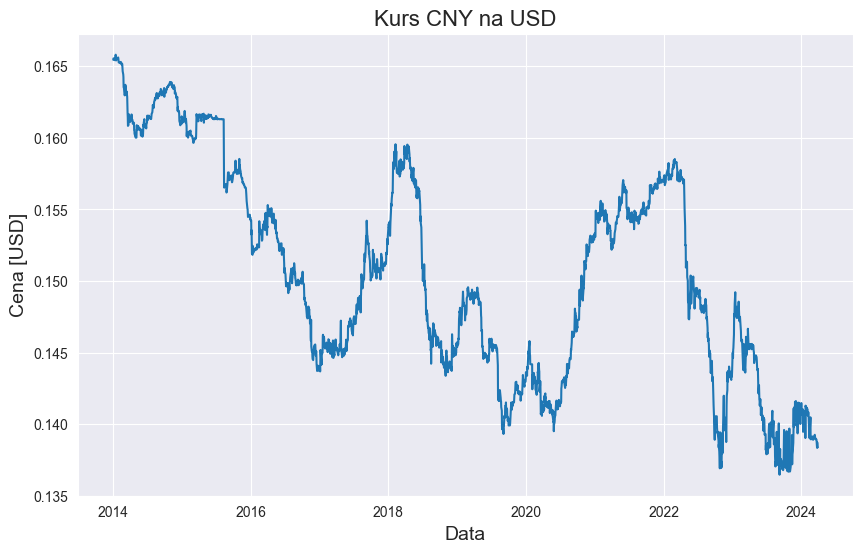

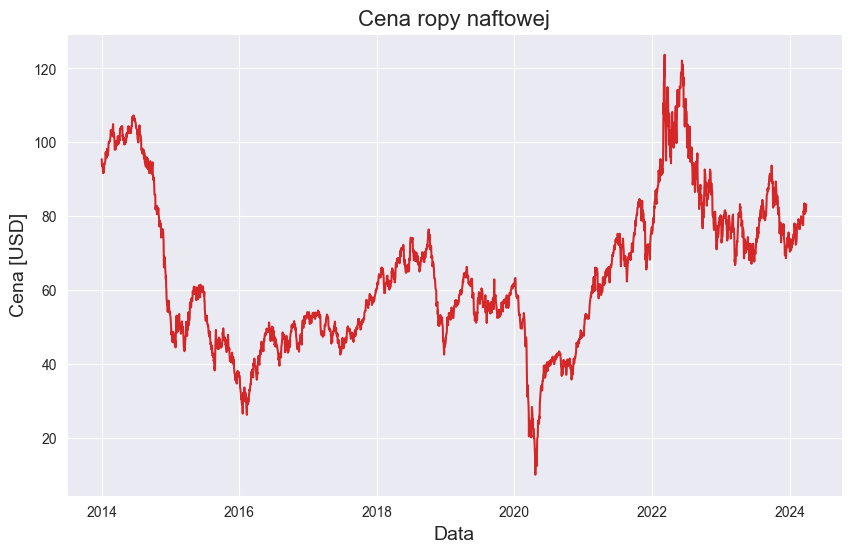

In [121]:
plt.figure(figsize=(10, 6))
plt.plot(Date, Currency, c="C0")
plt.title("Kurs CNY na USD", fontsize=16)
plt.xlabel("Data", fontsize=14)
plt.ylabel("Cena [USD]", fontsize=14)
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(Date, Oil, c="C3")
plt.title("Cena ropy naftowej", fontsize=16)
plt.xlabel("Data", fontsize=14)
plt.ylabel("Cena [USD]", fontsize=14)
plt.grid(True)
plt.show()


In [122]:
print(all_data.isnull().sum())

Ticker
oil         96
currency     4
dtype: int64


In [123]:
new_all_data = all_data.copy() 
new_all_data["oil"] = Oil
new_all_data["currency"] = Currency
Oil = new_all_data["oil"]
Currency = new_all_data["currency"]

In [124]:
print(new_all_data.isnull().sum())

Ticker
oil         0
currency    0
dtype: int64


In [125]:
new_all_data.head()

Ticker,oil,currency
Date,,
2014-01-02,95.440002,0.165453
2014-01-03,93.959999,0.165544
2014-01-06,93.430000,0.165522
2014-01-07,93.669998,0.165489
2014-01-08,92.330002,0.165530


### ACF przed czyszczeniem ( tylko wyrzucono NAN)

In [126]:
h = 100

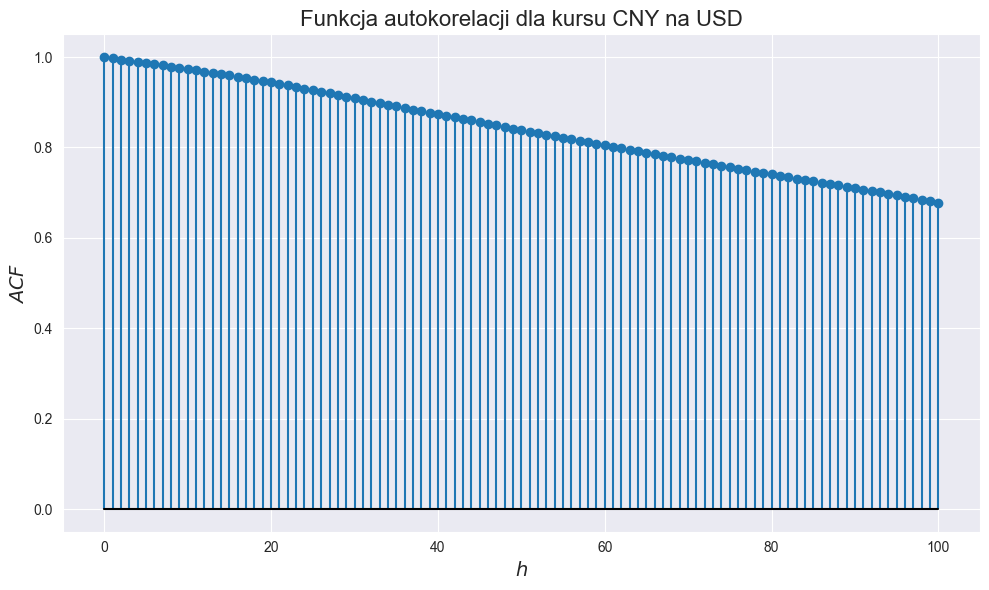

In [127]:
acf_currency = acf(Currency, nlags=h, fft=False)

plt.figure(figsize=(10, 6))
plt.stem(np.arange(0, h + 1), acf_currency, basefmt="black")
plt.title("Funkcja autokorelacji dla kursu CNY na USD", fontsize=16)
plt.xlabel("$h$", fontsize=14)
plt.ylabel("$ACF$", fontsize=14)
plt.tight_layout()
plt.show()

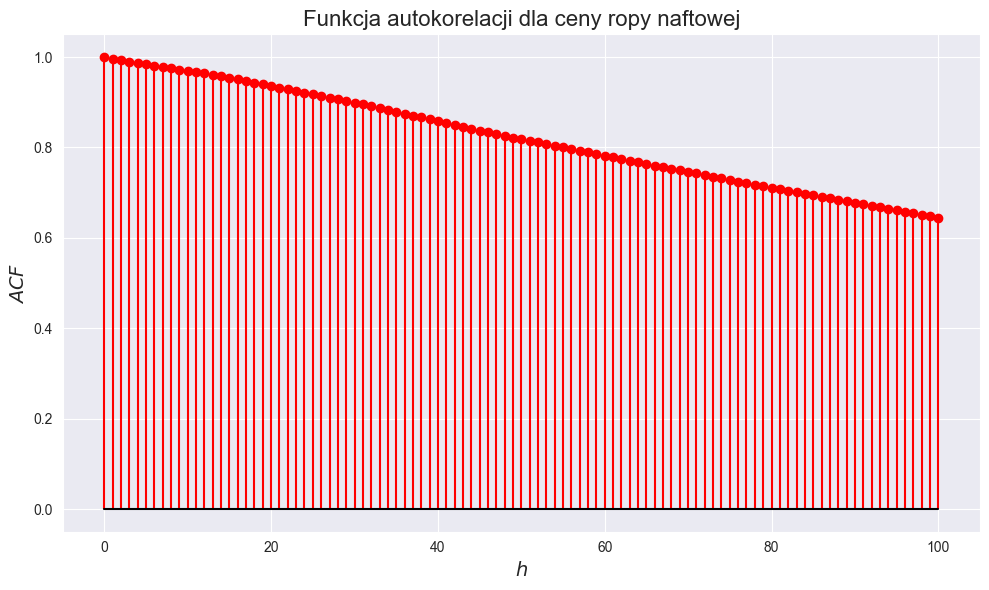

In [128]:
acf_currency = acf(Oil, nlags=h, fft=False)

plt.figure(figsize=(10, 6))
plt.stem(np.arange(0, h + 1), acf_currency, "r", markerfmt = "ro", basefmt='black')
plt.title("Funkcja autokorelacji dla ceny ropy naftowej", fontsize=16)
plt.xlabel("$h$", fontsize=14)
plt.ylabel("$ACF$", fontsize=14)
plt.tight_layout()
plt.show()

### **Transformacja danych**

In [139]:
# bc_Oil, lmbda, = stats.boxcox(Oil) #ewentualnie np.log
bc_Currency = stats.boxcox(Currency)[0]

# bc_Oil = pd.Series(bc_Oil)
bc_Currency = pd.Series(bc_Currency)

Oil_transformed = Oil.pct_change(fill_method=None)
# Oil_transformed, lmbda,  = stats.boxcox(Oil)
Oil_transformed = pd.Series(Oil_transformed)
Currency_transformed = bc_Currency.pct_change(fill_method=None)

print(sum(np.isnan(Oil_transformed)))
print(sum(np.isnan(Currency_transformed)))

nan_indices_oil = Oil_transformed.index[Oil_transformed.isna()]
nan_indices_currency = Currency_transformed.index[Currency_transformed.isna()]

print(nan_indices_oil)
print(nan_indices_currency)

1
1
DatetimeIndex(['2014-01-02'], dtype='datetime64[ns]', name='Date', freq='B')
Index([0], dtype='int64')


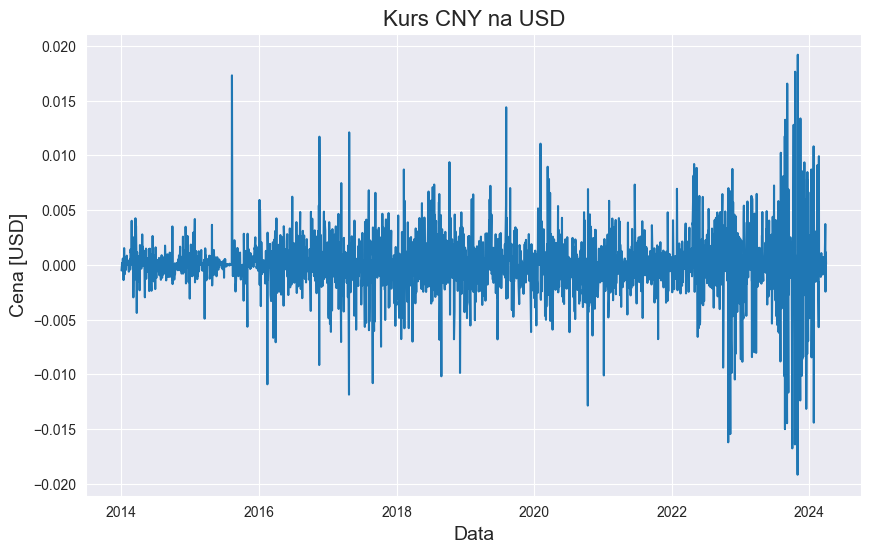

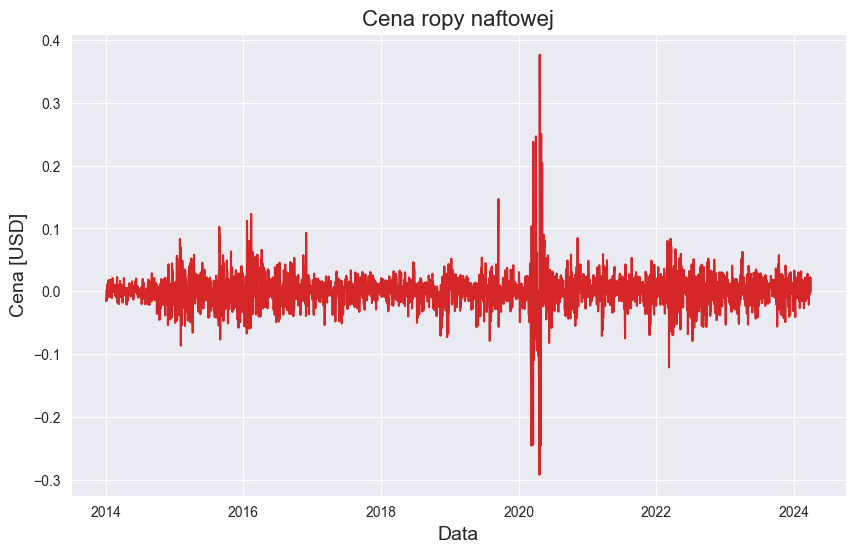

In [140]:
plt.figure(figsize=(10, 6))
plt.plot(Date, Currency_transformed, c="C0")
plt.title("Kurs CNY na USD", fontsize=16)
plt.xlabel("Data", fontsize=14)
plt.ylabel("Cena [USD]", fontsize=14)
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(Date, Oil_transformed, c="C3")
plt.title("Cena ropy naftowej", fontsize=16)
plt.xlabel("Data", fontsize=14)
plt.ylabel("Cena [USD]", fontsize=14)
plt.grid(True)
plt.show()

### ACF po transformacji( z wywaleniem NAN bo inaczej nie działa)

In [141]:
# Oil_clean_2 = Oil_transformed.dropna()
# Currency_clean_2 = Currency_transformed.dropna()

Oil_clean_2 = Oil_transformed.dropna()
Currency_clean_2 = Currency_transformed.dropna()
print(len(Date), len(Oil_clean_2), len(Currency_clean_2))

2672 2671 2671


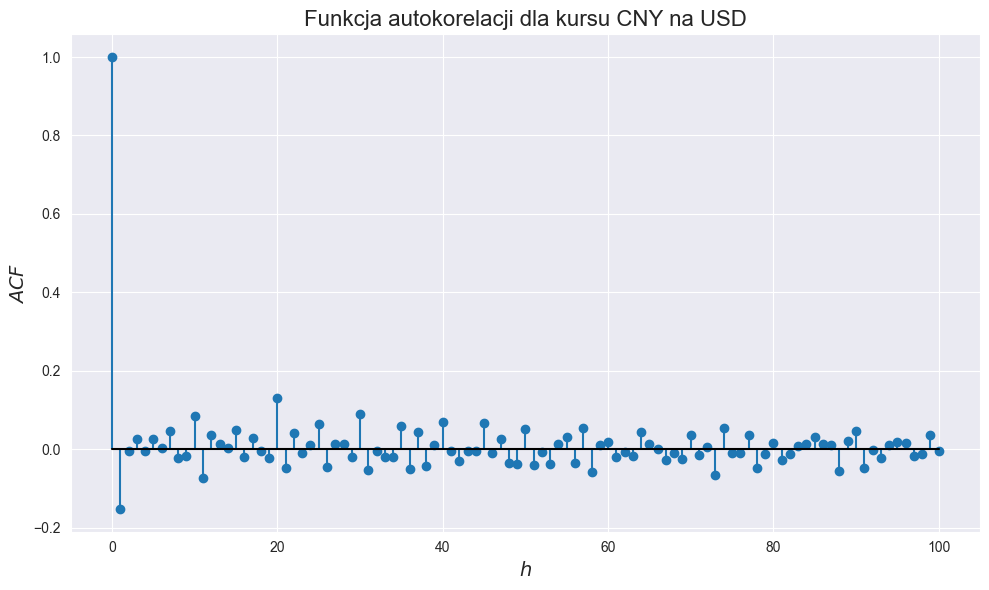

In [142]:
acf_currency = acf(Currency_clean_2, nlags=h, fft=False)

plt.figure(figsize=(10, 6))
plt.stem(np.arange(0, h + 1), acf_currency, basefmt="black")
plt.title("Funkcja autokorelacji dla kursu CNY na USD", fontsize=16)
plt.xlabel("$h$", fontsize=14)
plt.ylabel("$ACF$", fontsize=14)
plt.tight_layout()
plt.show()

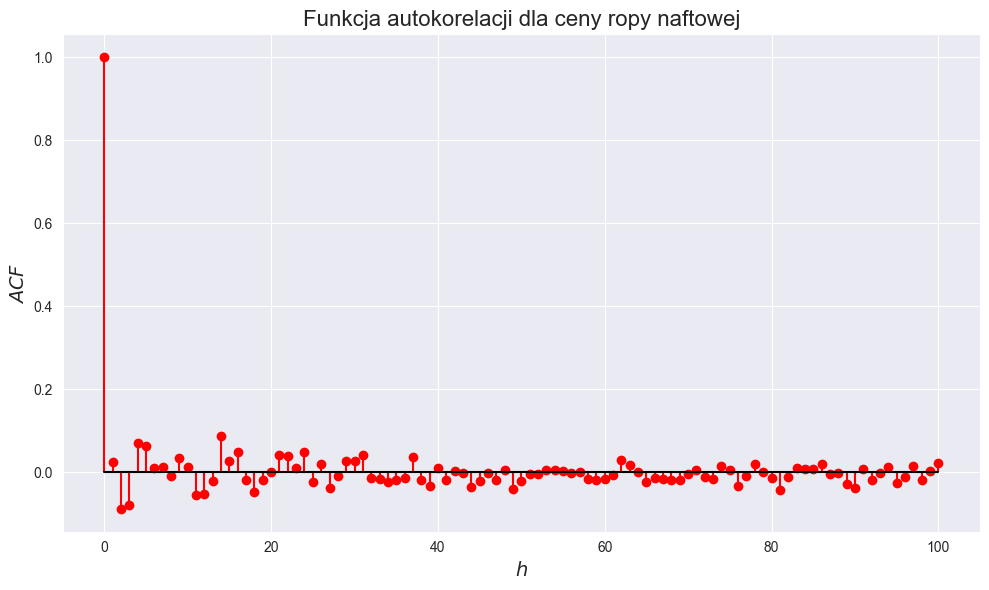

In [143]:
acf_currency = acf(Oil_clean_2, nlags=h, fft=False)

plt.figure(figsize=(10, 6))
plt.stem(np.arange(0, h + 1), acf_currency, "r", markerfmt = "ro", basefmt='black')
plt.title("Funkcja autokorelacji dla ceny ropy naftowej", fontsize=16)
plt.xlabel("$h$", fontsize=14)
plt.ylabel("$ACF$", fontsize=14)
plt.tight_layout()
plt.show()

### **ADF test**

In [144]:
def adfuller_test(series, sig=0.05): 
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3) 
    stats   = round(res[0], 3) 

    if p_value <= sig:
        print(f"Statystyka testowa = {stats}, p-Value = {p_value} => Stationary. ")
    else:
        print(f"Statystyka testowa = {stats}, p-value = {p_value} => Non-stationary.")

In [145]:
adfuller_test(Oil_clean_2)
adfuller_test(Currency_clean_2)

Statystyka testowa = -9.103, p-Value = 0.0 => Stationary. 
Statystyka testowa = -7.898, p-Value = 0.0 => Stationary. 


### **Miary zmienności**
nizej sa porownane od razu

In [146]:
# data = {
#     'Nazwa_miary_zmiennosci': ['Odchylenie_standardowe', 'Odchylenie_przecietne', 'Odchylenie_cwiartkowe', 'Semiodchylenie_standardowe', 'Semiodchylenie_przecietne'],
#     'Oil': [
#         np.std(Oil_clean_2),
#         np.mean(np.abs(Oil_clean_2 - np.mean(Oil_clean_2))),
#         (1/2) * (np.quantile(Oil_clean_2, 0.75, interpolation="midpoint") - np.quantile(Oil_clean_2, 0.25, interpolation="midpoint")),
#         np.std(Oil_clean_2[Oil_clean_2 < np.mean(Oil_clean_2)]),
#         np.mean(np.abs(Oil_clean_2[Oil_clean_2 < np.mean(Oil_clean_2)] - np.mean(Oil_clean_2)))
#     ],
#     'Currency': [
#         np.std(Currency_clean_2),
#         np.mean(np.abs(Currency_clean_2 - np.mean(Currency_clean_2))),
#         (1/2) * (np.quantile(Currency_clean_2, 0.75, interpolation="midpoint") - np.quantile(Currency_clean_2, 0.25, interpolation="midpoint")),
#         np.std(Currency_clean_2[Currency_clean_2 < np.mean(Currency_clean_2)]),
#         np.mean(np.abs(Currency_clean_2[Currency_clean_2 < np.mean(Currency_clean_2)] - np.mean(Currency_clean_2)))
#     ]
# }


# df = pd.DataFrame(data)
# df

### **Kwantyle**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


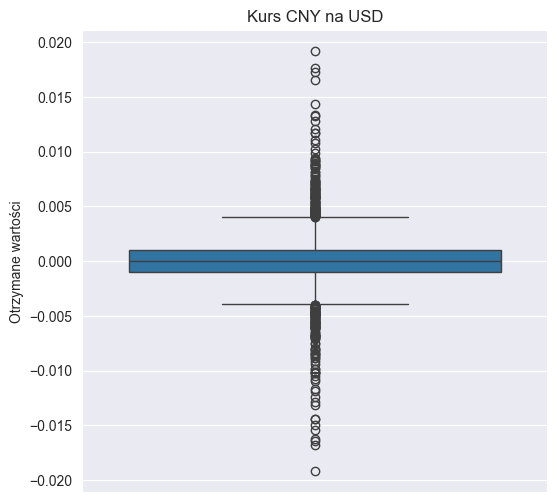

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


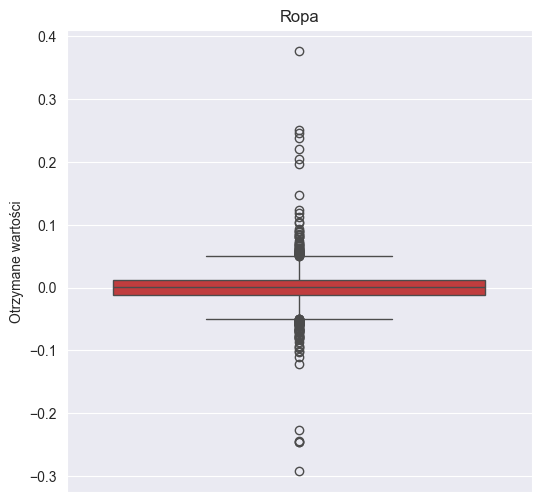

In [147]:
plt.figure(figsize=(6, 6))
sns.boxplot(Currency_transformed, color="C0") 
plt.ylabel("Otrzymane wartości")
plt.title("Kurs CNY na USD")
plt.legend(frameon=False, fontsize = 11)
plt.show()

plt.figure(figsize=(6, 6)) # są osobno bo razem źle wyglądały
sns.boxplot(Oil_transformed, color="C3") 
plt.ylabel("Otrzymane wartości")
plt.title("Ropa")
plt.legend(frameon=False, fontsize = 11)
plt.show()

In [148]:
oil_q1 = np.quantile(Oil_clean_2, 0.25, interpolation="midpoint")
oil_q2 = np.median(Oil_clean_2)
oil_q3 = np.quantile(Oil_clean_2, 0.75, interpolation="midpoint")

currency_q1 = np.quantile(Currency_clean_2, 0.25, interpolation="midpoint")
currency_q2 = np.median(Currency_clean_2)
currency_q3 = np.quantile(Currency_clean_2, 0.75, interpolation="midpoint")

data_q = {
    'Kwartyl': ['Q1', 'Q2', 'Q3'],
    'Oil': [oil_q1, oil_q2, oil_q3],
    'Currency': [currency_q1, currency_q2, currency_q3]
}

df = pd.DataFrame(data_q)
df


,Kwartyl,Oil,Currency
0,Q1,-0.012101,-0.000957
1,Q2,0.000828,0.000000
2,Q3,0.012772,0.001050


### **Wartosci dystrybuanty**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


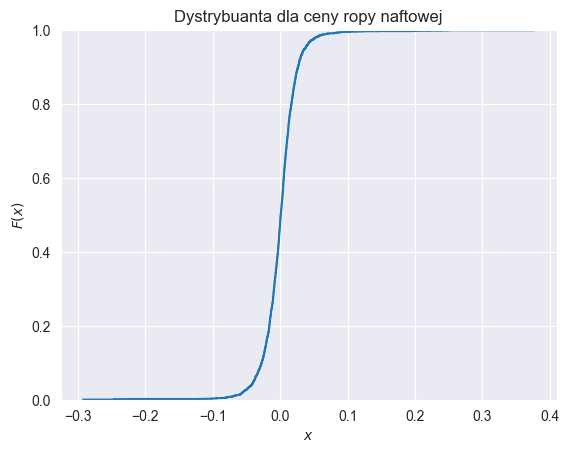

In [149]:
sns.ecdfplot(data = Oil_clean_2)
plt.title("Dystrybuanta dla ceny ropy naftowej")
plt.xlabel("$x$")
plt.ylabel("$F(x)$")
plt.legend(frameon=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


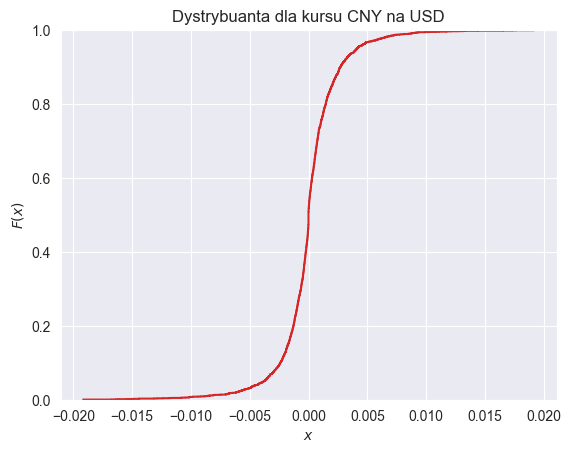

In [150]:
sns.ecdfplot(data = Currency_clean_2, c = 'C3')
plt.title("Dystrybuanta dla kursu CNY na USD")
plt.xlabel("$x$")
plt.ylabel("$F(x)$")
plt.legend(frameon=False)

### DOPASOWANIE ROZKŁADU

In [151]:
Oil_clean_2.index = date[1:]
Oil_clean_2, oil_test = Oil_clean_2[:'2022-12'], Oil_clean_2['2023-01']

In [152]:
params_Oil = stats.t.fit(Oil_clean_2)

t_student_Oil = stats.t(*params_Oil)

Oil_sample = t_student_Oil.rvs(size=len(Oil_clean_2))

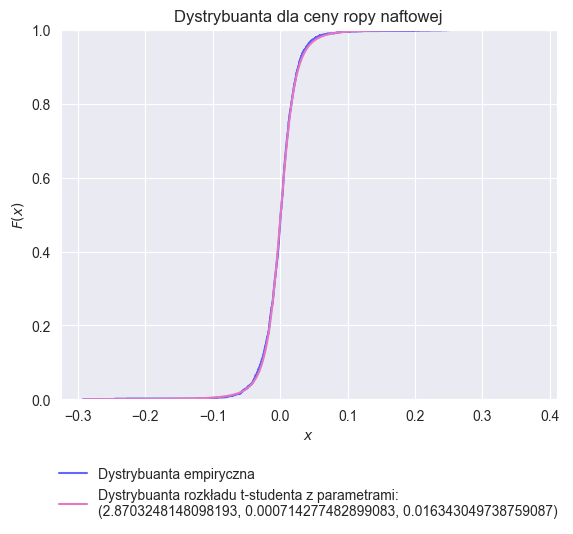

In [153]:
sns.ecdfplot(data = Oil_clean_2, label = "Dystrybuanta empiryczna", color = "b", alpha = 0.6)

t_Oil = np.linspace(np.min(Oil_clean_2), np.max(Oil_clean_2), len(Oil_clean_2))
th_F = t_student_Oil.cdf(t_Oil)
plt.plot(t_Oil, th_F, label = f"Dystrybuanta rozkładu t-studenta z parametrami: \n{params_Oil}", color = "C6")

plt.title("Dystrybuanta dla ceny ropy naftowej")
plt.xlabel("$x$")
plt.ylabel("$F(x)$")
_ = plt.legend(frameon=False,  loc='upper center', bbox_to_anchor=(0.5, -0.15))

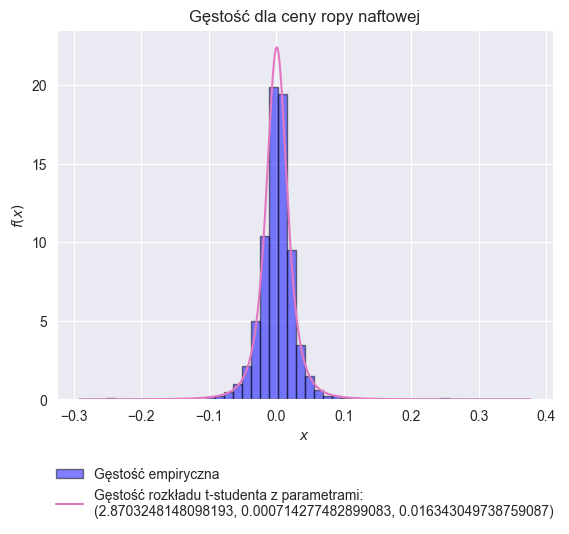

In [154]:
plt.hist(Oil_clean_2, bins = 50, edgecolor='k', density=True, label = "Gęstość empiryczna", color = "b", alpha = 0.5)

f_theo = t_student_Oil.pdf(t_Oil)
plt.plot(t_Oil, f_theo, label = f"Gęstość rozkładu t-studenta z parametrami: \n{params_Oil}", color = "C6")
plt.title("Gęstość dla ceny ropy naftowej")
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend(frameon=False,  loc='upper center', bbox_to_anchor=(0.5, -0.15))
plt.show()

Text(0.5, 1.0, 'Wykres kwantylowy dla próbki względem rozkładu t-Studenta')

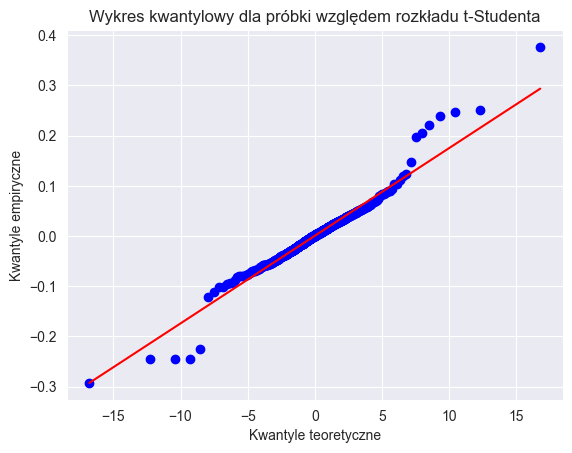

In [155]:
stats.probplot(Oil_clean_2, dist=stats.t, sparams=(params_Oil[0],), plot=plt)
plt.xlabel("Kwantyle teoretyczne")
plt.ylabel("Kwantyle empiryczne")
plt.title("Wykres kwantylowy dla próbki względem rozkładu t-Studenta")


### Przyszłość

In [156]:
from scipy.special import inv_boxcox

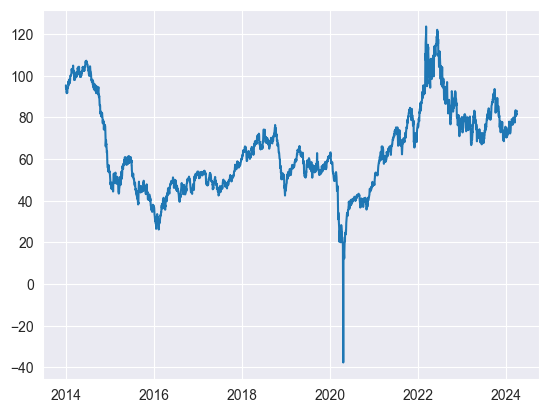

In [198]:
plt.plot(all_data.oil)

In [157]:
all_data = all_data.interpolate(method='linear')

In [206]:
n = len(all_data.loc['2022-12-30':])
m = 5000
k = len(all_data.loc['2021-12-30':'2022-12-30'])
alpha = 0.9
alpha2 = 0.7

In [207]:
sample_returns = [t_student_Oil.rvs(size=n) for _ in range(m)]
sample_prices = [(1 + returns).cumprod() * all_data.loc['2022-12-30'].oil for returns in sample_returns]

In [208]:
quantile_lower = np.quantile(sample_prices, 1 - alpha, axis=0)
quantile_upper = np.quantile(sample_prices, alpha, axis=0)

quantile_lower2 = np.quantile(sample_prices, 1 - alpha2, axis=0)
quantile_upper2 = np.quantile(sample_prices, alpha2, axis=0)

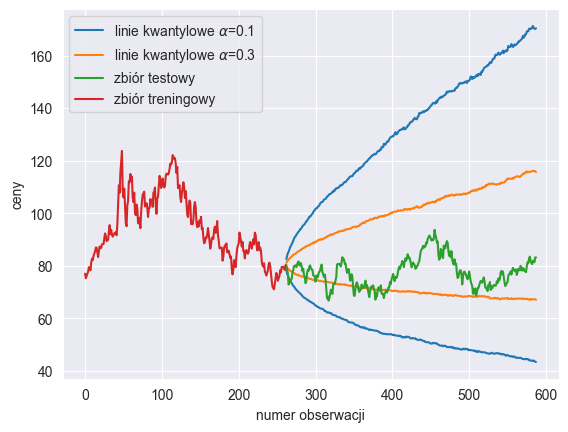

In [212]:
line1, = plt.plot(range(k, k+n), quantile_lower, c='C0')
line2, = plt.plot(range(k, k+n), quantile_upper, c='C0')
line3, = plt.plot(range(k, k+n), quantile_lower2, c='C1')
line4, = plt.plot(range(k, k + n), quantile_upper2, c='C1')
line5, = plt.plot(range(k, k+n), all_data['2022-12-30':].oil,  c='C2')
line6, = plt.plot(range(k), all_data['2021-12-30':'2022-12-30'].oil, c='C3')

plt.legend([line1, line3, line5, line6], [r'linie kwantylowe $\alpha$=0.1', r'linie kwantylowe $\alpha$=0.3', 'zbiór testowy', 'zbiór treningowy'])
plt.xlabel('numer obserwacji')
_ = plt.ylabel('ceny')

## **Miary ryzyka wyznaczone drugim sposobem**

In [ ]:
def semi_standard_deviation(data):
    mean = np.mean(data)  # Średnia
    deviations = data - mean  # Różnice od średniej
    negative_deviations = deviations[deviations < 0]  # Wybór tylko wartości ujemnych od średniej
    semi_std = np.mean(np.abs(negative_deviations))  # Średnia wartość bezwzględnych różnic ujemnych od średniej
    return semi_std

In [ ]:
data_Oil= {
    'Nazwa_miary_zmiennosci': ['Odchylenie_standardowe', 'Odchylenie_przecietne', 'Odchylenie_cwiartkowe', 'Semiodchylenie_standardowe', 'Semiodchylenie_przecietne'],
    'Oil_sample': [
        np.std(Oil_sample),
        np.mean(np.abs(Oil_sample - np.mean(Oil_sample))),
        (1/2) * (np.quantile(Oil_sample, 0.75, interpolation="midpoint") - np.quantile(Oil_sample, 0.25, interpolation="midpoint")),
        semi_standard_deviation(Oil_sample),
        np.mean(np.abs(Oil_sample[Oil_sample < np.mean(Oil_sample)] - np.mean(Oil_sample)))
    ],

    'Oil_from_data': [
        np.std(Oil_clean_2),
        np.mean(np.abs(Oil_clean_2 - np.mean(Oil_clean_2))),
        (1/2) * (np.quantile(Oil_clean_2, 0.75, interpolation="midpoint") - np.quantile(Oil_clean_2, 0.25, interpolation="midpoint")),
        semi_standard_deviation(Oil_clean_2),
        np.mean(np.abs(Oil_clean_2[Oil_clean_2 < np.mean(Oil_clean_2)] - np.mean(Oil_clean_2)))
    ]
}


df = pd.DataFrame(data_Oil)
df

In [ ]:
data = {
    'Nazwa_miary_zmiennosci': ['Odchylenie_standardowe', 'Odchylenie_przecietne', 'Odchylenie_cwiartkowe', 'Semiodchylenie_standardowe', 'Semiodchylenie_przecietne'],
    'Currency_sample': [
        np.std(Currency_sample),
        np.mean(np.abs(Currency_sample - np.mean(Currency_sample))),
        (1/2) * (np.quantile(Currency_sample, 0.75, interpolation="midpoint") - np.quantile(Currency_sample, 0.25, interpolation="midpoint")),
        semi_standard_deviation(Currency_sample),      
        np.mean(np.abs(Currency_sample[Currency_sample < np.mean(Currency_sample)] - np.mean(Currency_sample)))
    ],
    'Currency': [
        np.std(Currency_clean_2),
        np.mean(np.abs(Currency_clean_2 - np.mean(Currency_clean_2))),
        (1/2) * (np.quantile(Currency_clean_2, 0.75, interpolation="midpoint") - np.quantile(Currency_clean_2, 0.25, interpolation="midpoint")),
        semi_standard_deviation(Currency_clean_2),   
        np.mean(np.abs(Currency_clean_2[Currency_clean_2 < np.mean(Currency_clean_2)] - np.mean(Currency_clean_2)))
    ]
}


df = pd.DataFrame(data)
df

In [ ]:
# all_data_filtered = all_data.copy() 
# all_data_filtered["oil"] = Oil_transformed
# all_data_filtered["currency"] = Currency_transformed

# all_data_filtered.to_csv("oil_currency.csv", index=False)
# all_data_filtered

# 2. Przypadek wielowymiarowy

In [ ]:
a = 0.5
b = 0.5

Wallet = np.multiply(a, Oil_clean_2) + np.multiply(b, Currency_clean_2)
Date = Date[1:]

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(Date, Wallet, c="C9")
plt.title("Cena ropy naftowej", fontsize=16)
plt.xlabel("Data", fontsize=14)
plt.ylabel("Cena [USD]", fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
acf_currency = acf(Wallet, nlags=h, fft=False)

plt.figure(figsize=(10, 6))
plt.stem(np.arange(0, h + 1), acf_currency, linefmt='C9', markerfmt='C9o', basefmt='black')
plt.title("Funkcja autokorelacji portfela", fontsize=16)
plt.xlabel("$h$", fontsize=14)
plt.ylabel("$ACF$", fontsize=14)
plt.tight_layout()
plt.show()

### **Miara/y zmienności dla portfela**

In [ ]:
data = {
    'Nazwa_miary_zmiennosci': ['Odchylenie_standardowe', 'Odchylenie_przecietne', 'Odchylenie_cwiartkowe', 'Semiodchylenie_standardowe', 'Semiodchylenie_przecietne'],
    'Currency': [
        np.std(Currency_clean_2),
        np.mean(np.abs(Currency_clean_2 - np.mean(Currency_clean_2))),
        (1/2) * (np.quantile(Currency_clean_2, 0.75, interpolation="midpoint") - np.quantile(Currency_clean_2, 0.25, interpolation="midpoint")),
        semi_standard_deviation(Currency_clean_2),   
        np.mean(np.abs(Currency_clean_2[Currency_clean_2 < np.mean(Currency_clean_2)] - np.mean(Currency_clean_2)))
    ],
    'Oil': [
        np.std(Oil_clean_2),
        np.mean(np.abs(Oil_clean_2 - np.mean(Oil_clean_2))),
        (1/2) * (np.quantile(Oil_clean_2, 0.75, interpolation="midpoint") - np.quantile(Oil_clean_2, 0.25, interpolation="midpoint")),
        semi_standard_deviation(Oil_clean_2),
        np.mean(np.abs(Oil_clean_2[Oil_clean_2 < np.mean(Oil_clean_2)] - np.mean(Oil_clean_2)))
    ],
    'Wallet': [
        np.std(Wallet),
        np.mean(np.abs(Wallet - np.mean(Wallet))),
        (1/2) * (np.quantile(Wallet, 0.75, interpolation="midpoint") - np.quantile(Wallet, 0.25, interpolation="midpoint")),
        semi_standard_deviation(Wallet),
        np.mean(np.abs(Wallet[Wallet < np.mean(Wallet)] - np.mean(Wallet)))
    ]
}


df = pd.DataFrame(data)
df

### **Kwantyle**

In [ ]:
plt.figure(figsize=(6, 6)) 
sns.boxplot(list(Wallet), color="C9") 
plt.ylabel("Otrzymane wartości")
plt.title("Portfel")
plt.legend(frameon=False, fontsize = 11)
plt.show()

In [ ]:
wallet_q1 = np.quantile(Wallet, 0.25, interpolation="midpoint")
wallet_q2 = np.median(Wallet)
wallet_q3 = np.quantile(Wallet, 0.75, interpolation="midpoint")


data_q = {
    'Kwartyl': ['Q1', 'Q2', 'Q3'],
    'Wallet': [wallet_q1, wallet_q2, wallet_q3],
}

df = pd.DataFrame(data_q)
df


In [ ]:
sns.ecdfplot(data = Wallet, label = "Portfel", color = "C9")
sns.ecdfplot(data = Oil_clean_2, label = "ropa naftowa", color = "C0")
sns.ecdfplot(data = Currency_clean_2, label = "Kurs CNY na USD", color = "C3")
plt.title("Dystrybuanty")
plt.xlabel("$x$")
plt.ylabel("$F(x)$")
plt.legend(frameon=False, loc='upper center', bbox_to_anchor=(0.5, -0.15))

In [ ]:
params_Wallet = stats.t.fit(Wallet)
t_student_Wallet = stats.t(*params_Wallet)
Wallet_sample = t_student_Wallet.rvs(size=len(Wallet))

In [ ]:
sns.ecdfplot(data = Wallet, label = "Dystrybuanta empiryczna", color = "b", alpha = 0.6)

t_Wallet = np.linspace(np.min(Wallet), np.max(Wallet), len(Wallet))
th_F = t_student_Wallet.cdf(t_Wallet)
plt.plot(t_Wallet, th_F, label = f"Dystrybuanta portfela: \n{params_Wallet}",  color = "C6")

plt.title("Dystrybuanta portfela")
plt.xlabel("$x$")
plt.ylabel("$F(x)$")
plt.legend(frameon=False, loc='upper center', bbox_to_anchor=(0.5, -0.15))

In [ ]:
plt.hist(Wallet, bins = 50, edgecolor='k', density=True, label = "Gęstość empiryczna", color = "b", alpha = 0.5)

f_theo = t_student_Wallet.pdf(t_Wallet)
plt.plot(t_Wallet, f_theo, label = f"Gęstość rozkładu t-studenta z parametrami: \n{params_Wallet}", color = "C6")
plt.title("Gęstość portfela")
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend(frameon=False,  loc='upper center', bbox_to_anchor=(0.5, -0.15))
plt.show()

In [ ]:
stats.probplot(Oil_clean_2, dist=stats.t, sparams=(params_Oil[0],), plot=plt)
plt.xlabel("Kwantyle teoretyczne")
plt.ylabel("Kwantyle empiryczne")
plt.title("Wykres kwantylowy dla próbki względem rozkładu t-Studenta")

### drugi sposob na miary

In [ ]:
data = {
    'Nazwa_miary_zmiennosci': ['Odchylenie_standardowe', 'Odchylenie_przecietne', 'Odchylenie_cwiartkowe', 'Semiodchylenie_standardowe', 'Semiodchylenie_przecietne'],
    'Wallet_sample': [
        np.std(Wallet_sample),
        np.mean(np.abs(Wallet_sample - np.mean(Wallet_sample))),
        (1/2) * (np.quantile(Wallet_sample, 0.75, interpolation="midpoint") - np.quantile(Wallet_sample, 0.25, interpolation="midpoint")),
        semi_standard_deviation(Wallet_sample),   
        np.mean(np.abs(Wallet_sample[Wallet_sample < np.mean(Wallet_sample)] - np.mean(Wallet_sample)))
    ],
    'Wallet': [
        np.std(Wallet),
        np.mean(np.abs(Wallet - np.mean(Wallet))),
        (1/2) * (np.quantile(Wallet, 0.75, interpolation="midpoint") - np.quantile(Wallet, 0.25, interpolation="midpoint")),
        semi_standard_deviation(Wallet),
        np.mean(np.abs(Wallet[Wallet < np.mean(Wallet)] - np.mean(Wallet)))
    ]
}


df = pd.DataFrame(data)
df

### **Dystrybuanta 2 wymiarowa**

In [ ]:
H, xedges, yedges = np.histogram2d(Currency_clean_2, Oil_clean_2, bins=10, density=True)

plt.contourf(xedges[:-1], yedges[:-1], H.T, cmap='viridis')
plt.colorbar(label='')
plt.xlabel('Currency')
plt.ylabel('Oil')
plt.title('Dwuwymiarowa dystrybuanta')
